# Grafos de fluxos

Na sua versão mais simples, um *grafo de fluxos* é um grafo orientado onde cada aresta modela uma "conduta" onde pode fluir "alguma coisa" (gás, água, trânsito automóvel, etc) sujeita a uma capacidade máxima. Mais em informação em https://en.wikipedia.org/wiki/Flow_network.

Usando o `networkx` podemos modelar um grafo de fluxos usando um `DiGraph` (*directed graph*), usando atributos adicionais para representar a capacidade máxima de cada arco e o respectivo fluxo efectivo. Por exemplo, o seguinte código cria um grafo de fluxos com 6 nodos e 10 arcos, usando o atributo `capacity` para a guardar a capacidade máxima.

In [2]:
import networkx as nx

graph = nx.DiGraph()
graph.add_edge(0,1,capacity=16)
graph.add_edge(0,2,capacity=13)
graph.add_edge(1,2,capacity=10)
graph.add_edge(1,3,capacity=12)
graph.add_edge(2,1,capacity=4)
graph.add_edge(2,4,capacity=14)
graph.add_edge(3,2,capacity=9)
graph.add_edge(3,5,capacity=20)
graph.add_edge(4,3,capacity=7)
graph.add_edge(4,5,capacity=4)

Podemos desenhar este grafo de fluxos usando a seguinte função que assume que o grafo é planar e que coloca como fluxo efectivo o caracter `?` caso o atributo `flow` não esteja definido.

In [3]:
def draw_flow_network(graph):
    pos = nx.planar_layout(graph)
    labels = {}
    for (o,d) in graph.edges():
        if 'flow' in graph[o][d]:
            labels[(o,d)] = str(graph[o][d]['flow']) + ' / ' + str(graph[o][d]['capacity'])
        else:
            labels[(o,d)] = '? / ' + str(graph[o][d]['capacity'])                        
    nx.draw_networkx(graph,pos)
    nx.draw_networkx_edge_labels(graph,pos,labels,label_pos=0.3)


draw_flow_network(graph)

/home/jc/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
/home/jc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


## Max-flow

Um dos problemas clássicos com grafos de fluxos consiste em determinar qual o fluxo máximo que pode existir entre dois nodos concretos do grafo.

Usando programação inteira podemos determinar este fluxo máximo da seguinte forma.

### Análise do problema

Dado um grafo orientado $(V,E)$, uma capacidade $C_e \ge 0$ para cada arco $e \in E$, um nodo $s$ correspondente à origem e um nodo $t$ correspondente ao destino, precisamos de uma variável $f_e$ do tipo contínuo por cada arco $e \in E$. Para encontrar o fluxo máximo entre $s$ e $t$ basta maximizar

$$
\sum_{(s,v) \in E} f_{(s,v)}
$$

sujeito às seguintes restrições:
- A capacidade de cada arco é respeitada
- O fluxo que sai de cada nodo é igual ao que entra (exceptuando em $s$ e $t$)

### Exercício 1

Formalize estas restrições.

### Exercício 2

Implemente a função `max_flow` que dado um grafo de fluxos, determina o fluxo máximo entre `s` e `t`, definindo também o atributo `flow` com o fluxo efectivo de cada arco necessário para atingir esse fluxo máximo.

/home/jc/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


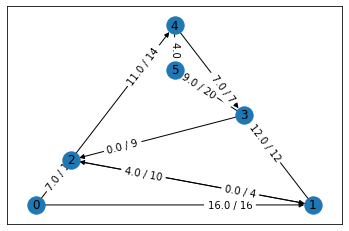

In [4]:
from pyscipopt import Model,quicksum

def max_flow(graph,s,t):
    
    m=Model()
    f = {}
    
    for (o,d) in graph.edges():
        f[(o,d)] = m.addVar('', 'C', lb = 0, ub = graph[o][d]['capacity'])
    
    for v in graph:
        if v != s and v != t:
            m.addCons(quicksum([ f[e] for e in graph.in_edges(v)]) == \
                      quicksum( [ f[e]  for e in graph.out_edges(v) ] ))
                            
    m.setObjective(quicksum( [f[e] for e in graph.in_edges(v)] ), sense = 'maximize')
    m.optimize()
    
    if m.getStatus() == 'optimal':
        r = sum([ m.getVal(f[e]) for e in graph.out_edges(s)])
        for (o,d) in graph.edges():
            graph[o][d]['flow'] = m.getVal(f[(o,d)])
        return r
    

assert max_flow(graph,0,5) == 23
draw_flow_network(graph)

## Min-cut

Um dos resultados fundamentais sobre grafos de fluxos, conforme https://en.wikipedia.org/wiki/Max-flow_min-cut_theorem, diz que o fluxo máximo entre dois vértices é igual à soma da capacidade dos arcos que estabelecem um *corte mínimo* entre esses vértices. Num grafo um *corte mínimo* é um conjunto de arcos que divide os nodos em dois conjuntos disjuntos satisfazendo algum critério de minimalidade. Neste caso estamos interessados em dividir o grafo em dois conjuntos $S$ e $T$ onde a origem $s \in S$ e o destino $t \in T$, minimizando a capacidade total dos arcos que pertecem ao corte, ou seja, a capacidade total dos arcos que ligam $S$ a $T$.

### Análise do problema

Dado um grafo orientado $(V,E)$, uma capacidade $C_e \ge 0$ para cada arco $e \in E$, um nodo $s$ correspondente à origem e um nodo $t$ correspondente ao destino, precisamos de uma variável binária $d_{(a,b)}$ por cada aresta $(a,b) \in E$, que terá o valor 1 se a respectiva aresta pertencer ao corte entre $S$ e $T$ (ou seja, se $a \in S$ e $b \in V$), e de uma variável binária $x_v$ por cada vértice $v \in V$, que terá o valor 1 se o respectivo vértice pertencer a $S$ (se o valor for 0 é porque $v \in T$). Para encontrar o corte mínimo basta minimizar

$$
\sum_{e \in E} d_{e} \cdot C_e
$$

sujeito às seguintes restrições:
- O nodo $s$ pertence a $S$ e o nodo $t$ pertence a $T$
- Uma aresta com origem em $S$ e destino em $T$ pertence ao corte

### Exercício 3

Formalize estas restrições.

### Exercício 4

Implemente a função `min_cut` que dado um grafo de fluxos determina o fluxo máximo entre `s` e `t`.

In [6]:
def min_cut(graph,s,t):
    m = Model()
    x = {}
    for v in graph:
        x[v] = m.addVar('', 'B')
    d = {}
    for e in graph.edges():
        d[e] = m.addVar('', 'B')
    
    m.addCons(x[s] == 1)
    m.addCons(x[t] == 0)
    
    for(a,b) in graph.edges():
        m.addCons(d[(a,b)] >= x[a] - x[b])
    
    m.setObjective(quicksum( [d[(a,b)] + graph[a][b]['capacity'] \
                             for (a,b) in graph.edges()] ), sense = 'minimize')
    
    m.optimize()
    if m.getStatus() == 'optimal':
        return sum(graph[a][b]['capacity'] \
                  for (a,b) in graph.edges() if m.getVal(d[a,b]) == 1)
    
assert min_cut(graph,0,5) == 23

AssertionError: 

## Outros problemas de corte mínimo

Outro problema relacionado com o corte mínimo consiste em determinar, para um grafo orientado e dois nodos $s$ e $t$ desse grafo, o número mínimo de arcos que é necessário retirar para que $t$ deixe de ser acessível a partir de $s$.

Uma forma directa de resolver este problema consiste em começar por determinar todos os caminhos (sem ciclos) entre $s$ e $t$ e depois determinar o conjunto mínimo de arestas que intersecta todos esses caminhos.

### Exercício 5

Formalize este problema usando programação inteira. Assuma que dado um grafo $(V,E)$ e os nodos $s$ e $t$, $P$ é o conjunto de todos os caminhos (sem ciclos) entre $s$ e $t$, onde cada caminho é representado pelo conjunto dos arcos que lhe pertencem.

### Exercício 6

Implemente a função `disconnect_all_paths` que dado um grafo `graph` e os nodos `s` e `t` devolve a lista de arestas a remover para que `t` deixe de ser acessível a partir de `s`. Pode usar a função `all_simple_paths` do `networkx` para determinar todos os caminhos sem ciclos entre dois vértices.

In [ ]:
def disconnect_all_paths(graph,s,t):
    # completar

disconnect_all_paths(graph,0,5)

### Exercício 7

Também é possível reduzir este problema ao problema do corte mínimo em grafos de fluxos assumindo simplesmente que a capacidade  dos arcos é 1.

Implemente a função `disconnect_min_cut` que dado um grafo `graph` e os nodos `s` e `t` devolve a lista de arestas a remover para que `t` deixe de ser acessível a partir de `s` usando esta técnica.

In [ ]:
def disconnect_min_cut(graph,s,t):
    # completar
    
disconnect_min_cut(graph,0,5)

### Exercício 8

Usando análise empírica da complexidade, compare a eficiência destas duas técnicas.